## Global libraries and Settings

In [ ]:
# this is used to include model diagram in this file. It is not related to the implementation
from IPython.display import Image

# torch and its modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader

# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms
import itertools
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np

import random

# for data
import kagglehub
import shutil
import os

# for evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
import numpy as np
import seaborn as sns

In [ ]:
# this is used to include model diagram in this file. It is not related to the implementation
from IPython.display import Image

# Install torch
%pip install torch

# torch and its modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader

# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np

import random

# for data
%pip install kagglehub
import kagglehub
import shutil
import os

# for evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
import numpy as np
import seaborn as sns

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

In [ ]:
data_dir = "CIFAKE"

if not os.path.exists(data_dir):
    print("CIFAKE dataset not found. Downloading and extracting...")

    # Download the dataset to the default location
    path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

    # Move the dataset to the target directory
    shutil.move(path, data_dir)

    print("CIFAKE dataset downloaded and prepared.")

else:
    print("CIFAKE dataset already exists. Skipping download and preparation.")

CIFAKE dataset not found. Downloading and extracting...


100%|██████████| 105M/105M [00:01<00:00, 84.5MB/s] 

Extracting files...


CIFAKE dataset downloaded and prepared.


In [ ]:
target_dir = "shoe"

# Check if the directory already exists
if not os.path.exists(target_dir):
    print("Dataset not found. Downloading and extracting...")
    path = kagglehub.dataset_download("sunnykakar/shoes-dataset-real-and-ai-generated-images")

    new_dir_names = {
        "ai-midjourney": "FAKE",
        "real": "REAL"
    }

    # Rename the directories within the dataset
    for old_name, new_name in new_dir_names.items():
        old_path = os.path.join(path, old_name)
        new_path = os.path.join(path, new_name)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)


    os.makedirs(target_dir, exist_ok=True)

    # Move only the renamed directories to the "shoe" directory
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):  # Only move directories
            shutil.move(item_path, os.path.join(target_dir, item))

    print("CIFAKE dataset downloaded and prepared.")
else:
    print("Dataset already exists. Skipping download and preparation.")

Dataset not found. Downloading and extracting...


100%|██████████| 37.2M/37.2M [00:00<00:00, 46.3MB/s]

Extracting files...


CIFAKE dataset downloaded and prepared.


In [ ]:
# this is used to include model diagram in this file. It is not related to the implementation
from IPython.display import Image

# torch and its modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader

# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np

import random

In [ ]:
'''
Prereq:
- pip3 install kaggle
- Get api: https://www.kaggle.com/docs/api#authentication

This script download the whole CIFAKE dataset (100ktrain, 20ktest) .zip to cwd.

At cwd, extract to folder `CIFAKE`,

and create folder `cifake_subsets` with same structure as `CIFAKE` with subset data
(25k train, 5ktest, balanced across 10 categories).

'''
data_path = "./CIFAKE"  # Define where the dataset will be extracted
output_dir = "./cifake_subsets"  # Folder to store subsets

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define folders and limits
subsets = {
    "test/FAKE": 2500,
    "test/REAL": 2500,
    "train/FAKE": 12500,
    "train/REAL": 12500,
}
for folder, limit in subsets.items():
    print(f"Processing {folder}...")

    source_folder = os.path.join(data_path, folder)
    target_folder = os.path.join(output_dir, folder)  # Keep the same directory structure

    # Check if the source folder exists
    if not os.path.exists(source_folder):
        print(f"Warning: {source_folder} does not exist. Skipping.")
        continue

    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Get the first `limit` files
    all_files = sorted(os.listdir(source_folder))[:limit]

    # Copy the selected files to the target folder
    for file in all_files:
        src = os.path.join(source_folder, file)
        dst = os.path.join(target_folder, file)
        shutil.copy(src, dst)

    print(f"Copied {limit} files from {folder} to {target_folder}.")

print(f"All subsets have been processed and saved to {output_dir}.")

Processing test/FAKE...
Copied 2500 files from test/FAKE to ./cifake_subsets/test/FAKE.
Processing test/REAL...
Copied 2500 files from test/REAL to ./cifake_subsets/test/REAL.
Processing train/FAKE...
Copied 12500 files from train/FAKE to ./cifake_subsets/train/FAKE.
Processing train/REAL...
Copied 12500 files from train/REAL to ./cifake_subsets/train/REAL.
All subsets have been processed and saved to ./cifake_subsets.


# 1. DATA

## 1.1 CIFAKE: trian and test set

In [ ]:
# Define test and train sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

data_path = "./cifake_subsets"  # subset
train_path = data_path + "/train"
test_path = data_path + "/test"
train_subset = DS.ImageFolder(root=train_path, transform=transform)
test_subset = DS.ImageFolder(root=test_path, transform=transform)

data_path_full = "./CIFAKE"  # full set
train_path_full = data_path_full + "/train"
test_path_full = data_path_full + "/test"
train_set = DS.ImageFolder(root=data_path_full + "/train", transform=transform)
test_set = DS.ImageFolder(root=data_path_full + "/test", transform=transform)

In [ ]:
# verify length
print("Train set length: ", len(train_set))
print("Test set length: ", len(test_set))
print("Train subset length: ", len(train_subset))
print("Test subset length: ", len(test_subset))

# verify classes
print(train_set.class_to_idx)

# verify image shape
print(train_set[0][0].shape)

Train set length:  100000
Test set length:  20000
Train subset length:  25000
Test subset length:  5000
{'FAKE': 0, 'REAL': 1}
torch.Size([3, 32, 32])


tensor([[[-0.1059, -0.0667, -0.0824,  ..., -0.0275, -0.1686, -0.5765],
         [-0.0039, -0.0039, -0.0275,  ..., -0.1922, -0.3647, -0.6392],
         [ 0.0431,  0.0039, -0.0196,  ..., -0.4353, -0.6078, -0.6863],
         ...,
         [-0.7176, -0.7098, -0.6941,  ..., -0.3020, -0.3098, -0.3020],
         [-0.7176, -0.7020, -0.6863,  ..., -0.2706, -0.3098, -0.3176],
         [-0.7255, -0.7098, -0.6706,  ..., -0.2157, -0.2235, -0.2314]],

        [[-0.1216, -0.0824, -0.0824,  ..., -0.0588, -0.2000, -0.6078],
         [-0.0196, -0.0196, -0.0275,  ..., -0.2235, -0.3961, -0.6706],
         [ 0.0275, -0.0118, -0.0196,  ..., -0.4667, -0.6392, -0.7098],
         ...,
         [-0.7882, -0.7804, -0.7647,  ..., -0.3569, -0.3647, -0.3569],
         [-0.7725, -0.7569, -0.7412,  ..., -0.3412, -0.3647, -0.3725],
         [-0.7647, -0.7490, -0.7255,  ..., -0.2863, -0.2863, -0.2941]],

        [[-0.1137, -0.0745, -0.0980,  ..., -0.0667, -0.2078, -0.6157],
         [-0.0118, -0.0118, -0.0431,  ..., -0

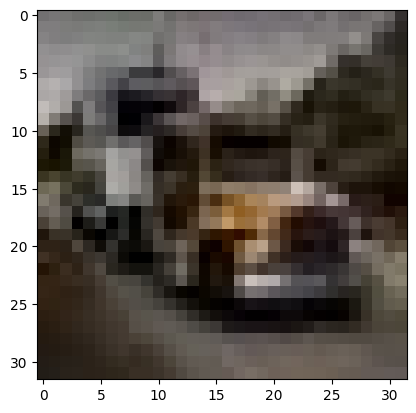

In [ ]:
# Get one sample from the dataset
image, label = train_set[0]
print(image)
print(f"Label: {label}")  # Display class name (FAKE or REAL: 0 or 1)

# Unnormalize and display the image
image = image / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
npimg = image.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
# train_loader: batch_size 32, test_loader: batch_size 64
train_loader_full = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader_full = DataLoader(test_set, batch_size=64, shuffle=False)

train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=False)

## 1.2 Shoe: additional test set

In [ ]:
# load shoe
import random

# Additional test set transformations
transform_additional_test = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to match CIFAKE input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Define the additional test dataset with the new transform
additional_test_set = DS.ImageFolder(root="./shoe", transform=transform_additional_test)
additional_test_loader = DataLoader(additional_test_set, batch_size=64, shuffle=False)

# Print information about the additional test set
print(f"Additional test set size: {len(additional_test_set)}")
print(f"Number of batches in additional test loader: {len(additional_test_loader)}")

Additional test set size: 2181
Number of batches in additional test loader: 35


In [ ]:
# print shoe image siz
print(additional_test_set[0][0].shape)

torch.Size([3, 32, 32])


# 2. Define train, test, additional test and evaluation functions

## 2.1. Define Test

In [ ]:
def test(model, loss_function, device, _test_loader: DataLoader):

    model = model.to(device = device)

    with torch.no_grad():
        risk = 0
        accuracy = 0

        for i, (images, labels) in enumerate(_test_loader):
            labels = labels.view(-1, 1).type(torch.float32)

            images = images.to(device = device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # determine the class of output from sigmoid output
            predicted = (outputs > 0.5).float()

            # compute the fraction of correctly predicted labels
            correct_predict = (predicted == labels).sum() / labels.size(0)

            risk += loss.item()
            accuracy += correct_predict.item()

        # average test risk and accuracy over the whole test dataset
        test_risk = risk / len(_test_loader)
        test_accuracy = accuracy / len(_test_loader)

    return test_risk, test_accuracy

## 2.2 Define train (with fixed epoches & early stop)

In [ ]:
def train(model, num_epochs, device, _train_loader, _test_loader):

    model = model.to(device = device)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initiate the values
    train_risk = []
    test_risk = []
    test_accuracy = []

    for epoch in range(num_epochs):
        risk = 0
        model.train()

        for i, (images, labels) in enumerate(_train_loader):
            labels = labels.view(-1, 1).type(torch.float32)
            images = images.to(device = device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # one step of gradient descent
            optimizer.step()

        # first we tell pytorch we are doing evaluation (reassure it, as we have already included it in test())
        model.eval()

        # test out model after update by the optimizer
        risk_epoch, accuracy_epoch = test(model, loss_function, device, _test_loader)
        train_risk.append(risk/len(_train_loader))
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # we can print a message every second epoch
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch}], \
                Train Risk: {train_risk[-1]:.4f}, \
                Test Risk: {test_risk[-1]:.4f}, \
                Test Accuracy: {test_accuracy[-1]:.4f}')

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot([i + 1 for i in range(len(train_risk))], train_risk, label='train')
    axs[0].plot([i + 1 for i in range(len(test_risk))], test_risk, label='test')
    axs[0].legend()
    axs[0].set_title('Train and Test Risk')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Risk')

    # Plot the test accuracy on the second subplot
    axs[1].plot([i + 1 for i in range(len(test_accuracy))], test_accuracy)
    axs[1].set_title('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return train_risk, test_risk, test_accuracy

In [ ]:
def train_early_stop(model, num_epochs, target_accuracy, device, _train_loader, _test_loader):
    """
    Train the model with early stopping when the target accuracy is reached.

    Args:
        model: The neural network model to train.
        num_epochs: The maximum number of epochs to train.
        target_accuracy: The target accuracy to stop training early.
        device: The device to train the model on (CPU or GPU).

    Returns:
        train_risk, test_risk, test_accuracy: Lists containing training risk, test risk, and test accuracy per epoch.
    """
    model = model.to(device)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initialize lists to store metrics
    train_risk = []
    test_risk = []
    test_accuracy = []

    for epoch in range(num_epochs):
        risk = 0
        model.train()  # Set model to training mode

        for i, (images, labels) in enumerate(_train_loader):
            labels = labels.view(-1, 1).type(torch.float32)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Collect the training loss
            risk += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient descent step
            optimizer.step()

        # Evaluate the model after traini
        model.eval()
        risk_epoch, accuracy_epoch = test(model, loss_function, device,
                                           _test_loader=_test_loader)
        train_risk.append(risk / len(_train_loader))
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # Print progress every second epoch
        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch + 1}], '
                  f'Train Risk: {train_risk[-1]:.4f}, '
                  f'Test Risk: {test_risk[-1]:.4f}, '
                  f'Test Accuracy: {test_accuracy[-1]:.4f}')

        # Check for early stopping
        if accuracy_epoch >= target_accuracy:
            print(f"Target accuracy of {target_accuracy:.4f} reached at epoch {epoch + 1}. Stopping training.")
            break

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot([i + 1 for i in range(len(train_risk))], train_risk, label='train')
    axs[0].plot([i + 1 for i in range(len(test_risk))], test_risk, label='test')
    axs[0].legend()
    axs[0].set_title('Train and Test Risk')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Risk')

    # Plot the test accuracy on the second subplot
    axs[1].plot([i + 1 for i in range(len(test_accuracy))], test_accuracy)
    axs[1].set_title('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return train_risk, test_risk, test_accuracy

## 2.3 Define Additional Test

In [ ]:
def additional_test(model, loss_function, device, _additional_test_loader: DataLoader):
    """
    Test the trained model on a separate additional test dataset.

    Args:
        model: The trained CNN model.
        loss_function: Loss function to evaluate the additional test performance.
        device: Device to perform computations (CPU/GPU).
        _additional test_loader: DataLoader for the additional test dataset.

    Returns:
        additional test_risk: Average loss on the additional test set.
        additional test_accuracy: Accuracy on the additional test set.
    """
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        risk = 0
        accuracy = 0

        for images, labels in _additional_test_loader:
            labels = labels.view(-1, 1).type(torch.float32)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Determine predicted classes from sigmoid output
            predicted = (outputs > 0.5).float()

            # Compute accuracy
            correct_predict = (predicted == labels).sum() / labels.size(0)

            risk += loss.item()
            accuracy += correct_predict.item()

        # Average risk and accuracy
        additional_test_risk = risk / len(_additional_test_loader)
        additional_test_accuracy = accuracy / len(_additional_test_loader)

    print(f"additional test Risk: {additional_test_risk:.4f}, additional test Accuracy: {additional_test_accuracy:.4f}")
    return additional_test_risk, additional_test_accuracy

## 2.4 Define Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    all_outputs = []  # For probabilities

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary (threshold = 0.5)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels).flatten()
    all_predictions = np.array(all_predictions).flatten()
    all_outputs = np.array(all_outputs).flatten()

    # Calculate performance metrics
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, zero_division=0)
    auc = roc_auc_score(all_labels, all_outputs)
    logloss = log_loss(all_labels, all_outputs)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    kappa = cohen_kappa_score(all_labels, all_predictions)

    return conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa


In [ ]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# 3. Models

## 3.1 CNN

Layer	               Input Shape	   Output Shape

Conv2D Layer 1	       (32, 32, 3)	   (30, 30, 32) activate ReLu

MaxPooling2D Layer 1   (30, 30, 32)	   (15, 15, 32)

Conv2D Layer 2	       (15, 15, 32)	   (13, 13, 64) activate ReLu

MaxPooling2D Layer 2   (13, 13, 64)	   (6, 6, 64)

Conv2D Layer 3	       (6, 6, 64)	   (4, 4, 128) activate ReLu

MaxPooling2D Layer 3   (4, 4, 128)	   (2, 2, 128)

Flatten	               (2, 2, 128)	   (512)

Dense Layer 1	       (512)	       (256) activate ReLu

Dropout	               (256)	       (256)

Dense Layer 2	       (256)	       (1) activate sigmoid

In [ ]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()

        # Conv2D Layer 1: input (3 channels), output (32 channels), kernel size (3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)  # Output: (30, 30, 32)
        self.relu1 = nn.ReLU()  # Activation
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Output: (15, 15, 32)

        # Conv2D Layer 2: input (32 channels), output (64 channels), kernel size (3x3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)  # Output: (13, 13, 64)
        self.relu2 = nn.ReLU()  # Activation
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Output: (6, 6, 64)

        # Conv2D Layer 3: input (64 channels), output (128 channels), kernel size (3x3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)  # Output: (4, 4, 128)
        self.relu3 = nn.ReLU()  # Activation
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # Output: (2, 2, 128)

        # Fully connected layers
        self.flatten = nn.Flatten()  # Flatten the tensor to prepare for fully connected layers
        self.fc1 = nn.Linear(in_features=2 * 2 * 128, out_features=256)  # First fully connected layer
        self.relu_fc1 = nn.ReLU()  # Activation
        self.dropout = nn.Dropout(p=0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(in_features=256, out_features=1)  # Final fully connected layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        # Conv2D Layer 1
        x = self.conv1(x)  # Convolution
        x = self.relu1(x)  # Activation
        x = self.pool1(x)  # MaxPooling

        # Conv2D Layer 2
        x = self.conv2(x)  # Convolution
        x = self.relu2(x)  # Activation
        x = self.pool2(x)  # MaxPooling

        # Conv2D Layer 3
        x = self.conv3(x)  # Convolution
        x = self.relu3(x)  # Activation
        x = self.pool3(x)  # MaxPooling

        # Flatten
        x = self.flatten(x)  # Flatten to (batch_size, 512)

        # Fully connected layers
        x = self.fc1(x)  # Dense Layer 1
        x = self.relu_fc1(x)  # Activation
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)  # Dense Layer 2
        x = self.sigmoid(x)  # Sigmoid Activation (for binary classification)

        return x

## 3.2 ResNet

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights, resnet101, ResNet101_Weights

class MyResNet(nn.Module):
    def __init__(self, model):
        super(MyResNet, self).__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)  # Apply sigmoid for binary classification
        return x


resnet18_v1 = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
resnet18_v1.fc = nn.Linear(resnet18_v1.fc.in_features, 1)  # 1 output for binary classification
model18_v1 = MyResNet(resnet18_v1)

resnet50_v1 = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
resnet50_v1.fc = nn.Linear(resnet50_v1.fc.in_features, 1)  # 1 output for binary classification
model50_v1 = MyResNet(resnet50_v1)

resnet50_v2 = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
resnet50_v2.fc = nn.Linear(resnet50_v2.fc.in_features, 1)  # 1 output for binary classification
model50_v2 = MyResNet(resnet50_v2)

resnet101_v1 = resnet101(weights = ResNet101_Weights.IMAGENET1K_V1)
resnet101_v1.fc = nn.Linear(resnet101_v1.fc.in_features, 1)  # 1 output for binary classification
model101_v1 = MyResNet(resnet101_v1)

resnet101_v2 = resnet101(weights = ResNet101_Weights.IMAGENET1K_V2)
resnet101_v2.fc = nn.Linear(resnet101_v2.fc.in_features, 1)  # 1 output for binary classification
model101_v2 = MyResNet(resnet101_v2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 57.7MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 154MB/s]


In [ ]:
print(resnet18_v1)
print(resnet50_v1)
print(resnet101_v1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Train and Measure performance

## Untrained model

In [ ]:
# untrained model
model_untrained = myCNN()
risk, accuracy = test(model_untrained, nn.BCELoss(), device, test_loader_subset)
print(f"Average Risk: {risk:.4f}, Accuracy: {accuracy:.4f}")

Average Risk: 0.6934, Accuracy: 0.4982


In [ ]:
# Measure Performance Using evaluate_model for untrained model
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model_untrained, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.51      0.01      0.02      2500
           1       0.50      0.99      0.66      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.34      5000
weighted avg       0.50      0.50      0.34      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.4563
Log Loss: 0.6935
Matthews Correlation Coefficient: 0.0020
Balanced Accuracy: 0.5002
Cohen's Kappa: 0.0004


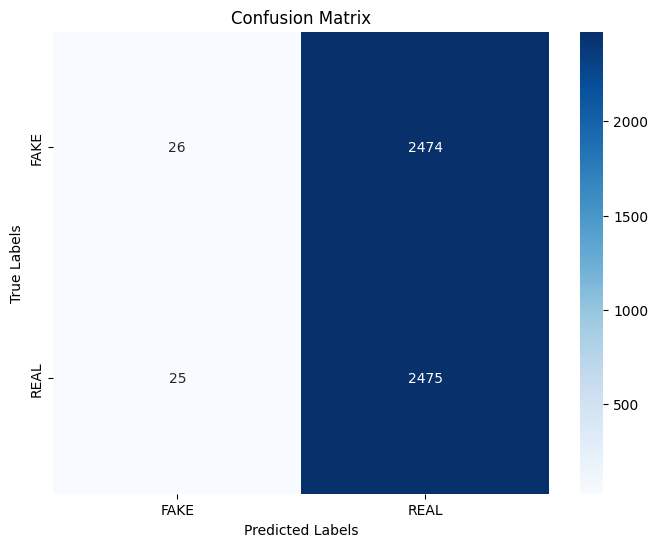

In [ ]:
# Plot the heatmap
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Simple_CNN with fiexed epoches

Epoch [1],                 Train Risk: 0.2927,                 Test Risk: 0.2763,                 Test Accuracy: 0.8861
Epoch [3],                 Train Risk: 0.2235,                 Test Risk: 0.2515,                 Test Accuracy: 0.8995
Epoch [5],                 Train Risk: 0.1687,                 Test Risk: 0.2363,                 Test Accuracy: 0.9064
Epoch [7],                 Train Risk: 0.1216,                 Test Risk: 0.2284,                 Test Accuracy: 0.9201
Epoch [9],                 Train Risk: 0.0870,                 Test Risk: 0.2828,                 Test Accuracy: 0.9171


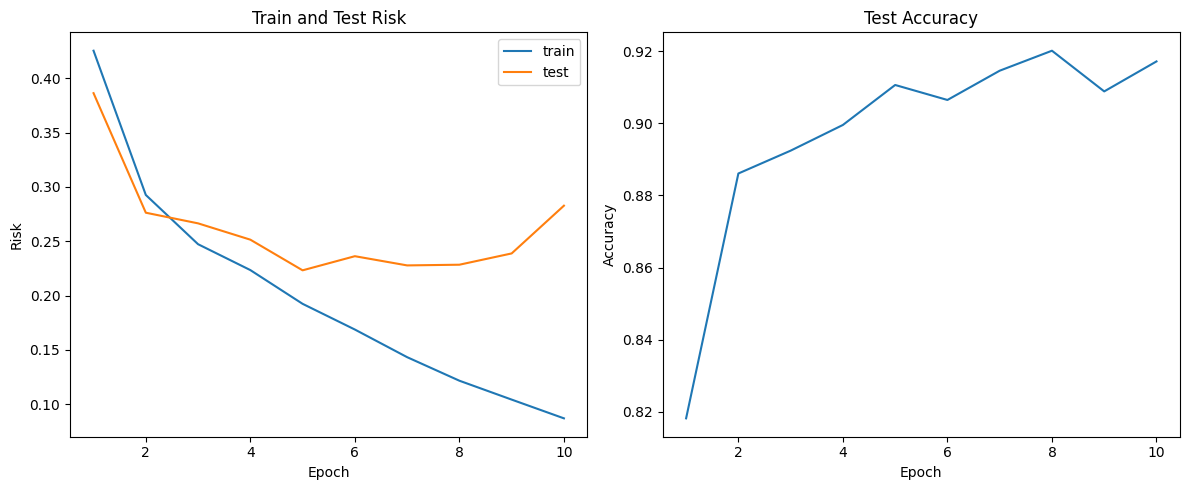

In [ ]:
# model trained with fixed epoches
model_cnn_fixedEpoches = myCNN()
num_epochs = 10
train_risk, test_risk, test_accuracy = train(model_cnn_fixedEpoches, num_epochs, device,
                                             _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
# Measure Performance Using evaluate_model for model trained with fixed epoches
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model_cnn_fixedEpoches, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2500
           1       0.92      0.91      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9697
Log Loss: 0.2849
Matthews Correlation Coefficient: 0.8324
Balanced Accuracy: 0.9162
Cohen's Kappa: 0.8324


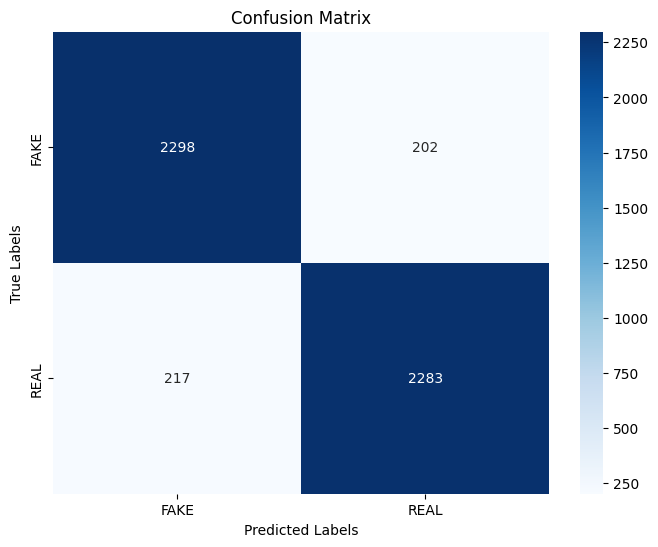

In [ ]:
# Plot the heatmap
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Simple_CNN with early stopping

Epoch [2], Train Risk: 0.2932, Test Risk: 0.2709, Test Accuracy: 0.8898
Epoch [4], Train Risk: 0.2164, Test Risk: 0.2259, Test Accuracy: 0.9102
Epoch [6], Train Risk: 0.1750, Test Risk: 0.2196, Test Accuracy: 0.9094
Epoch [8], Train Risk: 0.1407, Test Risk: 0.2480, Test Accuracy: 0.9175
Epoch [10], Train Risk: 0.1013, Test Risk: 0.2583, Test Accuracy: 0.9114


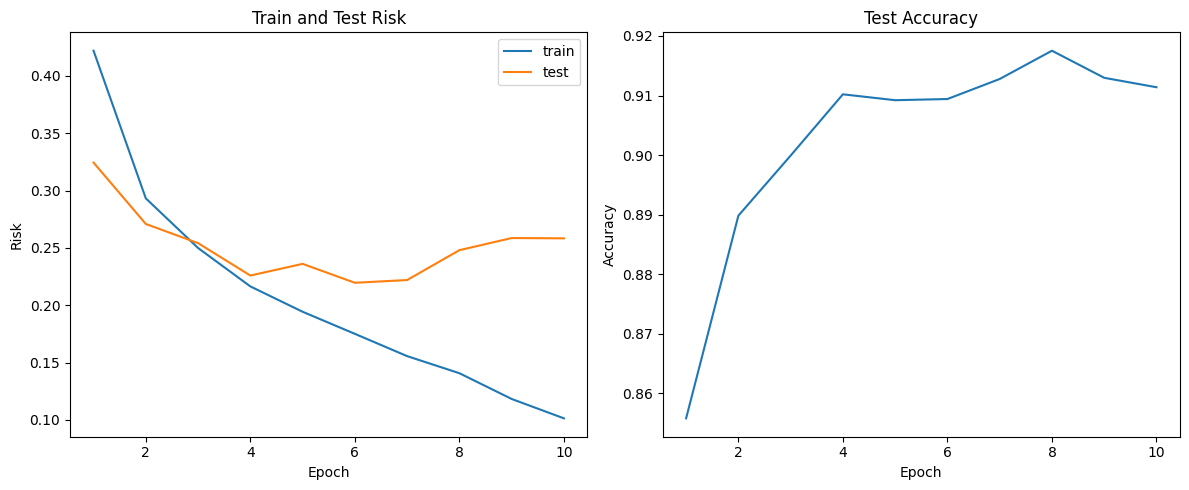

In [ ]:
# model trained with early stopping
model_cnn_earlyStop = myCNN()
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model_cnn_earlyStop, num_epochs, target_accuracy, device,
                                                        _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model_cnn_earlyStop, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2500
           1       0.89      0.94      0.91      2500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9713
Log Loss: 0.2605
Matthews Correlation Coefficient: 0.8224
Balanced Accuracy: 0.9104
Cohen's Kappa: 0.8208


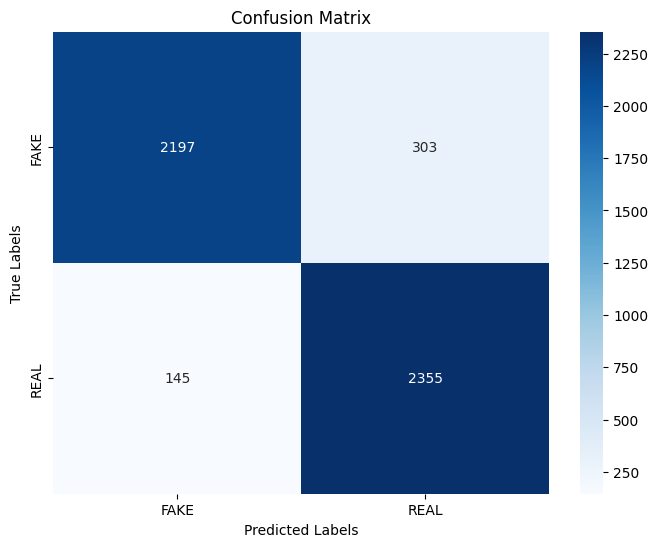

In [ ]:
# Plot the heatmap
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Resnet 18_v1

Epoch [2], Train Risk: 0.1975, Test Risk: 0.1829, Test Accuracy: 0.9223
Epoch [4], Train Risk: 0.1374, Test Risk: 0.1582, Test Accuracy: 0.9379
Epoch [6], Train Risk: 0.1121, Test Risk: 0.1648, Test Accuracy: 0.9377
Epoch [8], Train Risk: 0.0863, Test Risk: 0.1914, Test Accuracy: 0.9258
Epoch [10], Train Risk: 0.0535, Test Risk: 0.1809, Test Accuracy: 0.9365


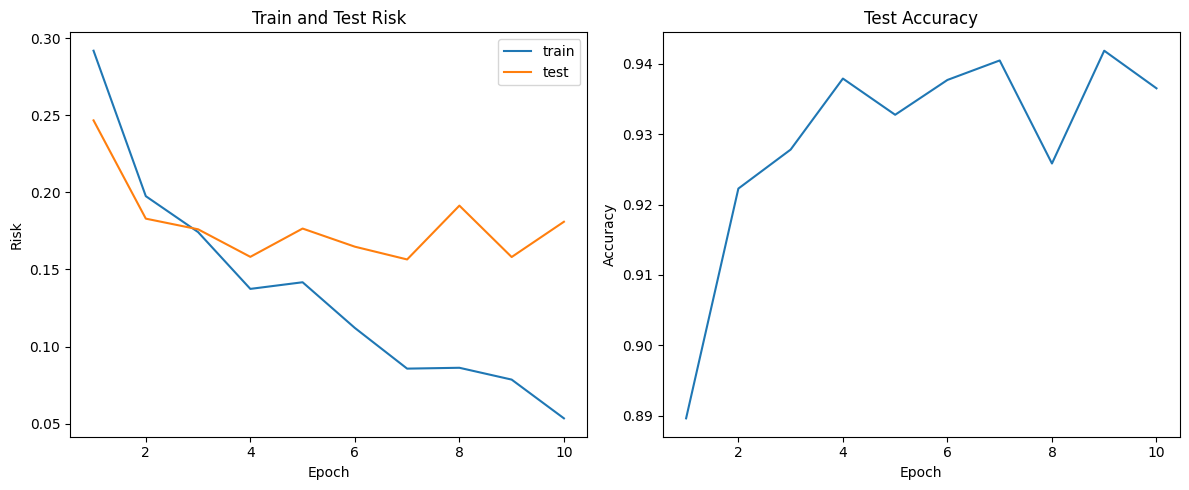

In [ ]:
# model trained with resnet 18_v1
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model18_v1, num_epochs, target_accuracy,
                                             device, _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model18_v1, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2500
           1       0.93      0.94      0.94      2500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9821
Log Loss: 0.1825
Matthews Correlation Coefficient: 0.8716
Balanced Accuracy: 0.9358
Cohen's Kappa: 0.8716


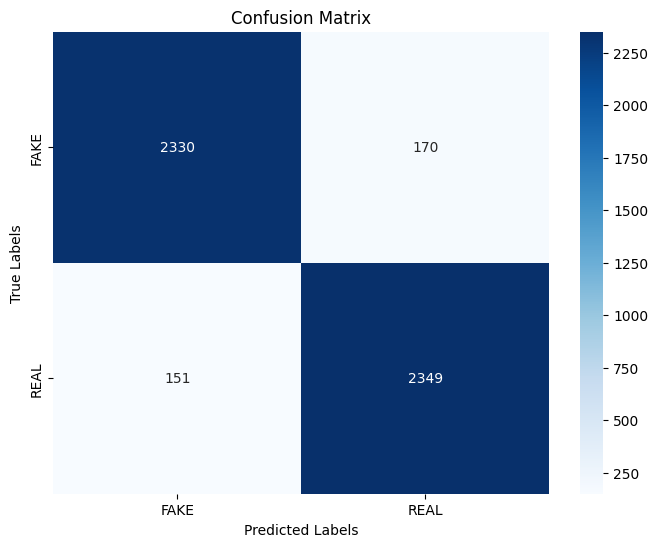

In [ ]:
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Resnet 50_v1

Epoch [2], Train Risk: 0.1882, Test Risk: 0.1735, Test Accuracy: 0.9330
Epoch [4], Train Risk: 0.1409, Test Risk: 0.1583, Test Accuracy: 0.9395
Epoch [6], Train Risk: 0.1636, Test Risk: 0.2198, Test Accuracy: 0.9130
Epoch [8], Train Risk: 0.3023, Test Risk: 0.2325, Test Accuracy: 0.9128
Epoch [10], Train Risk: 0.1477, Test Risk: 0.1870, Test Accuracy: 0.9337


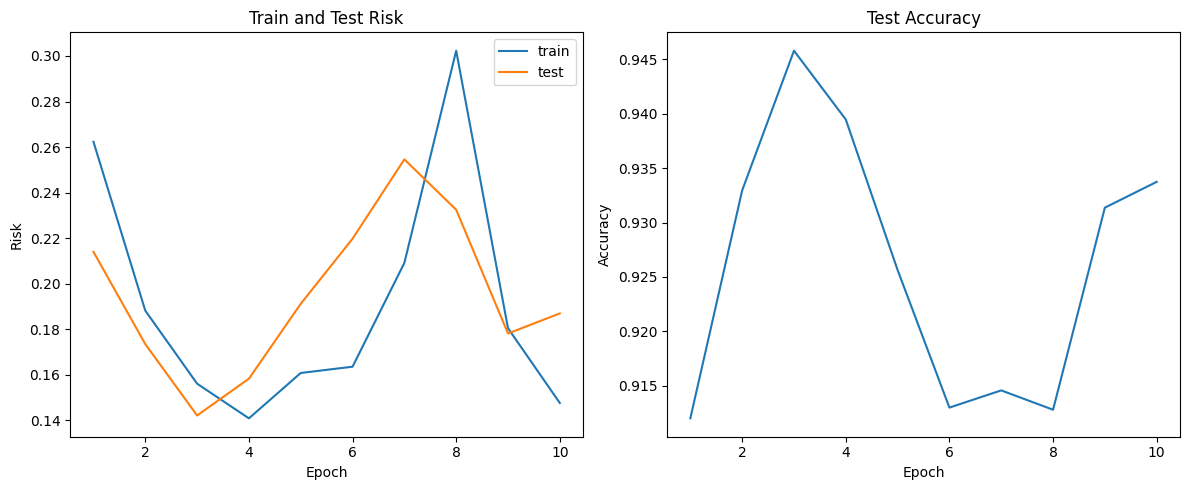

In [ ]:
# model trained with resnet 50_v1
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model50_v1, num_epochs, target_accuracy,
                                             device, _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model50_v1, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2500
           1       0.94      0.93      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9809
Log Loss: 0.1795
Matthews Correlation Coefficient: 0.8689
Balanced Accuracy: 0.9344
Cohen's Kappa: 0.8688


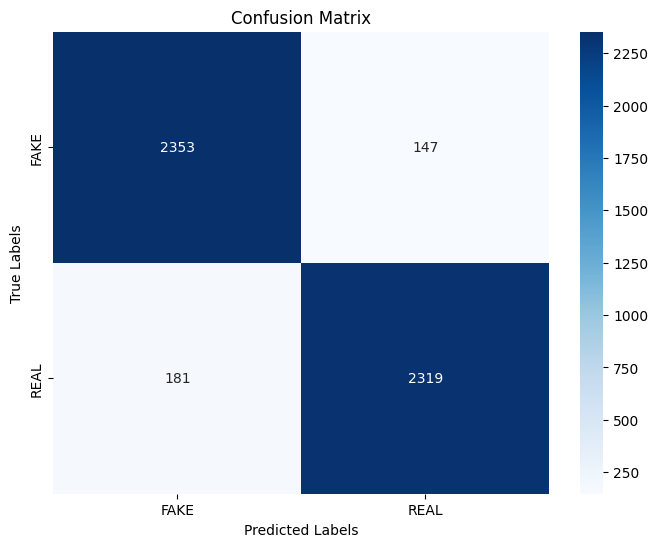

In [ ]:
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Resnet 50_v2

Epoch [2], Train Risk: 0.1723, Test Risk: 0.2010, Test Accuracy: 0.9209
Epoch [4], Train Risk: 0.1242, Test Risk: 0.2032, Test Accuracy: 0.9231
Epoch [6], Train Risk: 0.0992, Test Risk: 0.1896, Test Accuracy: 0.9333
Epoch [8], Train Risk: 0.0731, Test Risk: 0.1518, Test Accuracy: 0.9436
Epoch [10], Train Risk: 0.0698, Test Risk: 0.1278, Test Accuracy: 0.9569
Target accuracy of 0.9500 reached at epoch 10. Stopping training.


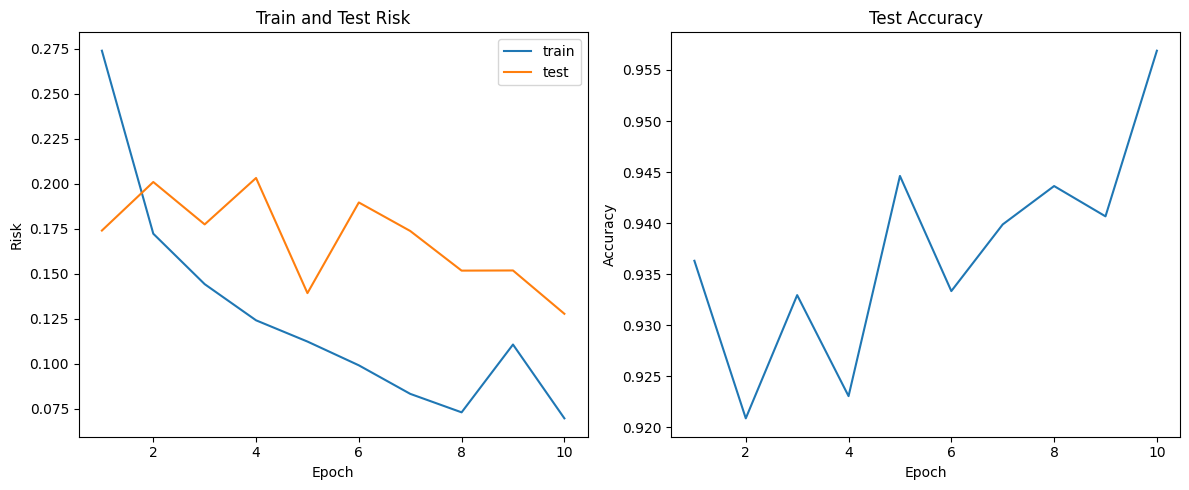

In [ ]:
# model trained with resnet 50_v2
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model50_v2, num_epochs, target_accuracy,
                                             device, _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model50_v2, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2500
           1       0.96      0.95      0.96      2500

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9902
Log Loss: 0.1290
Matthews Correlation Coefficient: 0.9128
Balanced Accuracy: 0.9564
Cohen's Kappa: 0.9128


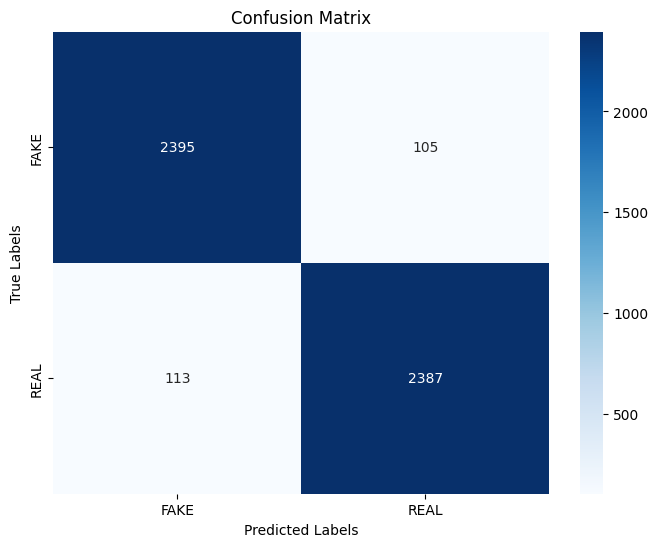

In [ ]:
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Resnet 101_v1

Epoch [2], Train Risk: 0.2318, Test Risk: 0.2329, Test Accuracy: 0.9066
Epoch [4], Train Risk: 0.2321, Test Risk: 0.2550, Test Accuracy: 0.9066
Epoch [6], Train Risk: 0.3116, Test Risk: 0.4153, Test Accuracy: 0.8683
Epoch [8], Train Risk: 0.8627, Test Risk: 0.5564, Test Accuracy: 0.7389
Epoch [10], Train Risk: 0.4140, Test Risk: 0.9894, Test Accuracy: 0.8208


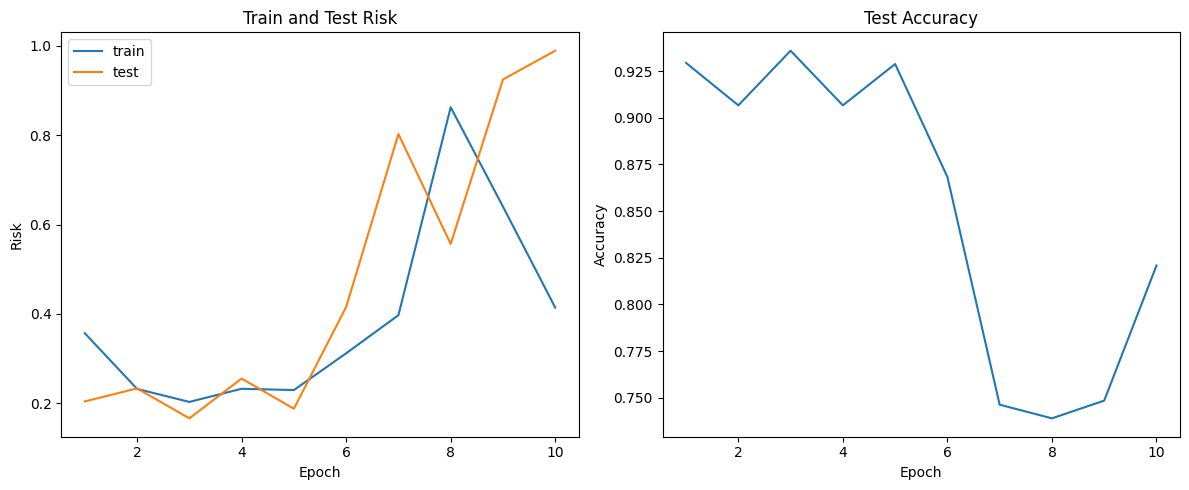

In [ ]:
# model trained with resnet 101_v1
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model101_v1, num_epochs, target_accuracy,
                                             device, _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model101_v1, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2500
           1       0.79      0.87      0.83      2500

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.8787
Log Loss: 0.7678
Matthews Correlation Coefficient: 0.6431
Balanced Accuracy: 0.8202
Cohen's Kappa: 0.6404


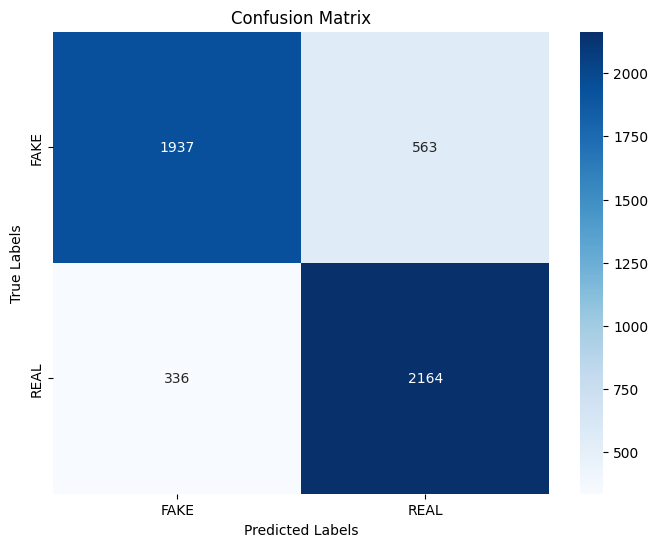

In [ ]:
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

## Resnet 101_v2

Epoch [2], Train Risk: 0.2073, Test Risk: 0.3726, Test Accuracy: 0.8904
Epoch [4], Train Risk: 0.1360, Test Risk: 0.1553, Test Accuracy: 0.9393
Epoch [6], Train Risk: 0.1032, Test Risk: 1.4237, Test Accuracy: 0.7939
Epoch [8], Train Risk: 0.0707, Test Risk: 0.1501, Test Accuracy: 0.9430
Epoch [10], Train Risk: 0.0625, Test Risk: 0.3388, Test Accuracy: 0.8881


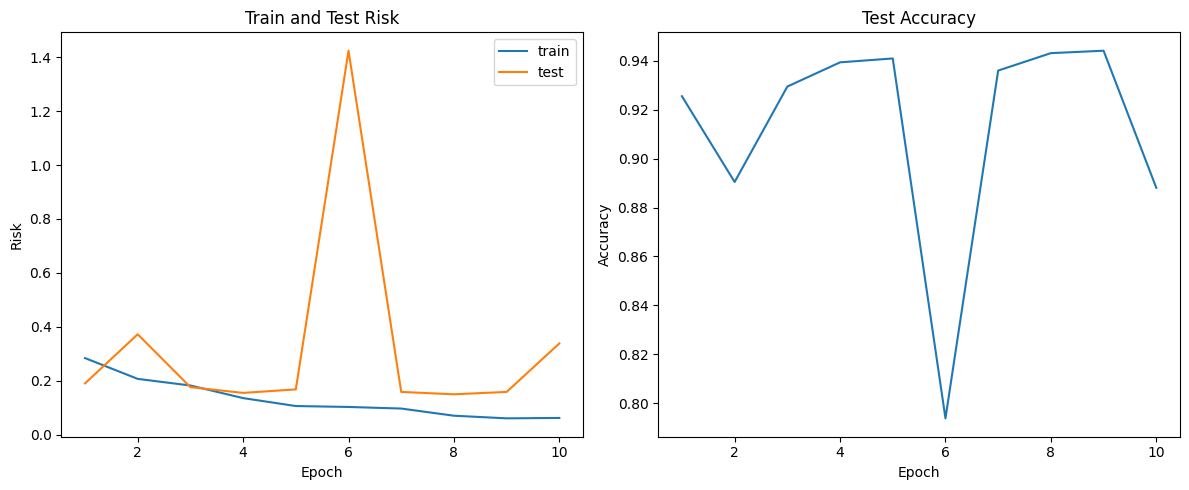

In [ ]:
# model trained with resnet 101_v2
num_epochs = 10
target_accuracy = 0.95
train_risk, test_risk, test_accuracy = train_early_stop(model101_v2, num_epochs, target_accuracy,
                                             device, _train_loader=train_loader_subset, _test_loader=test_loader_subset)

In [ ]:
conf_matrix, class_report, auc, logloss, mcc, balanced_acc, kappa = evaluate_model(model101_v2, test_loader_subset, device)
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      2500
           1       0.82      0.99      0.90      2500

    accuracy                           0.89      5000
   macro avg       0.90      0.89      0.89      5000
weighted avg       0.90      0.89      0.89      5000



In [ ]:
print(f"AUC-ROC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

AUC-ROC: 0.9845
Log Loss: 0.3426
Matthews Correlation Coefficient: 0.7912
Balanced Accuracy: 0.8868
Cohen's Kappa: 0.7736


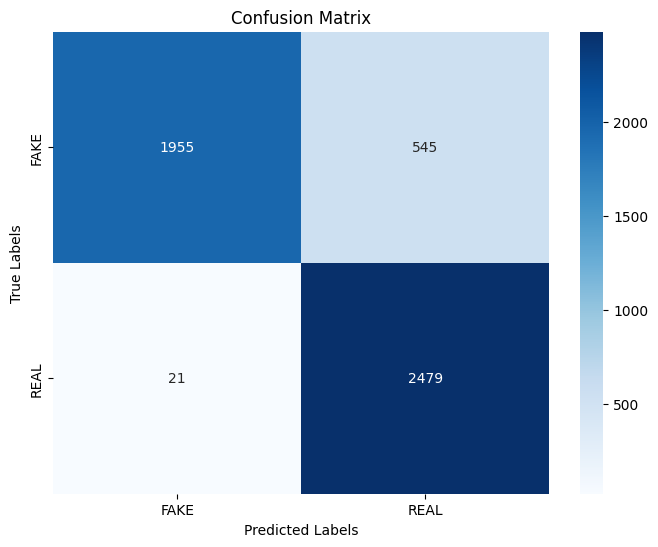

In [ ]:
plot_confusion_matrix(conf_matrix, train_set.class_to_idx.keys())

# Generalize

In [ ]:
additional_test(model_untrained, nn.BCELoss(), device, additional_test_loader)
additional_test(model_cnn_earlyStop, nn.BCELoss(), device, additional_test_loader)
additional_test(model_cnn_fixedEpoches, nn.BCELoss(), device, additional_test_loader)
additional_test(model18_v1, nn.BCELoss(), device, additional_test_loader)
additional_test(model50_v1, nn.BCELoss(), device, additional_test_loader)
additional_test(model50_v2, nn.BCELoss(), device, additional_test_loader)
additional_test(model101_v1, nn.BCELoss(), device, additional_test_loader)
additional_test(model101_v2, nn.BCELoss(), device, additional_test_loader)

Validation Risk: 0.6981, Validation Accuracy: 0.3549
Validation Risk: 2.8354, Validation Accuracy: 0.5426
Validation Risk: 3.1386, Validation Accuracy: 0.4752
Validation Risk: 1.7939, Validation Accuracy: 0.5447
Validation Risk: 1.4016, Validation Accuracy: 0.5465
Validation Risk: 2.2100, Validation Accuracy: 0.5555
Validation Risk: 5.9554, Validation Accuracy: 0.3114
Validation Risk: 4.5177, Validation Accuracy: 0.4665


(4.517653904376285, 0.46651785714285715)